# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math, random
import seaborn as sns
from datetime import datetime
import datetime as dt
import yfinance as yf
import preprocessor as p
import re
from alpha_vantage.timeseries import TimeSeries
from sklearn.metrics import mean_squared_error


plt.style.use('ggplot')
sns.set_style('whitegrid')

%matplotlib inline


# Getting Data from yFinance  

In [2]:
def get_historical(quote):
        end = datetime.now()
        start = datetime(end.year-3,end.month,end.day)
        data = yf.download(quote, start=start, end=end)
        df = pd.DataFrame(data=data)
        df.to_csv(''+quote+'.csv')
        if(df.empty):
            ts = TimeSeries(key='N6A6QT6IBFJOPJ70',output_format='pandas')
            data, meta_data = ts.get_daily_adjusted(symbol='NSE:'+quote, outputsize='full')
            #Format df
            #Last 2 yrs rows => 502, in ascending order => ::-1
            data=data.head(503).iloc[::-1]
            data=data.reset_index()
            #Keep Required cols only
            df=pd.DataFrame()
            df['Date']=data['date']
            df['Open']=data['1. open']
            df['High']=data['2. high']
            df['Low']=data['3. low']
            df['Close']=data['4. close']
            df['Adj Close']=data['5. adjusted close']
            df['Volume']=data['6. volume']
            df.to_csv(''+quote+'.csv',index=False)
        return

In [3]:
# Company's Sticker 
quote = 'TATASTEEL.NS'
get_historical(quote)

[*********************100%***********************]  1 of 1 completed


In [4]:
df = pd.read_csv(''+quote+'.csv')
print("##############################################################################")
print("Today's",quote,"Stock Data: ")
today_stock=df.iloc[-1:]
print(today_stock)
print("##############################################################################")
df = df.dropna()
code_list=[]
for i in range(0,len(df)):
    code_list.append(quote)
df2=pd.DataFrame(code_list,columns=['Code'])
df2 = pd.concat([df2, df], axis=1)
df=df2


##############################################################################
Today's TATASTEEL.NS Stock Data: 
           Date   Open   High    Low       Close   Adj Close    Volume
747  2023-01-05  116.5  117.0  114.5  116.550003  116.550003  58792148
##############################################################################


# Analysing Data

In [5]:
df

,Code,Date,Open,High,Low,Close,Adj Close,Volume
0,TATASTEEL.NS,2020-01-06,48.000000,48.000000,47.055000,47.325001,20.056345,96016080
1,TATASTEEL.NS,2020-01-07,47.549999,48.459999,47.355000,47.610001,20.177128,131957880
2,TATASTEEL.NS,2020-01-08,47.165001,47.814999,46.700001,47.525002,20.141106,133048410
3,TATASTEEL.NS,2020-01-09,48.500000,48.599998,47.910000,48.314999,20.475906,101311520
4,TATASTEEL.NS,2020-01-10,48.549999,49.384998,48.000000,48.619999,20.605165,159276340
...,...,...,...,...,...,...,...,...
743,TATASTEEL.NS,2022-12-30,112.900002,114.750000,112.099998,112.650002,112.650002,56048485
744,TATASTEEL.NS,2023-01-02,114.400002,119.699997,113.750000,119.250000,119.250000,143444095
745,TATASTEEL.NS,2023-01-03,119.800003,120.500000,117.750000,118.449997,118.449997,74419090
746,TATASTEEL.NS,2023-01-04,118.750000,119.050003,115.349998,115.750000,115.750000,55634568


In [6]:
# Summary Stats
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,748.000000,748.000000,748.000000,748.000000,748.000000,7.480000e+02
mean,86.621076,87.972627,85.116624,86.496196,48.814227,1.298302e+08
std,37.490774,37.908917,36.896661,37.366794,30.881669,8.515757e+07
min,26.225000,26.795000,25.084999,25.375000,10.753930,6.744340e+06
25%,44.688749,45.403749,43.862501,44.373751,19.003201,7.212108e+07
50%,100.724998,101.917500,99.437500,100.592503,48.886560,1.094637e+08
75%,116.425001,117.896248,114.391253,116.526251,59.741148,1.657249e+08
max,151.940002,153.449997,149.175003,151.940002,119.250000,6.428460e+08


In [7]:
# General info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Code       748 non-null    object 
 1   Date       748 non-null    object 
 2   Open       748 non-null    float64
 3   High       748 non-null    float64
 4   Low        748 non-null    float64
 5   Close      748 non-null    float64
 6   Adj Close  748 non-null    float64
 7   Volume     748 non-null    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 46.9+ KB


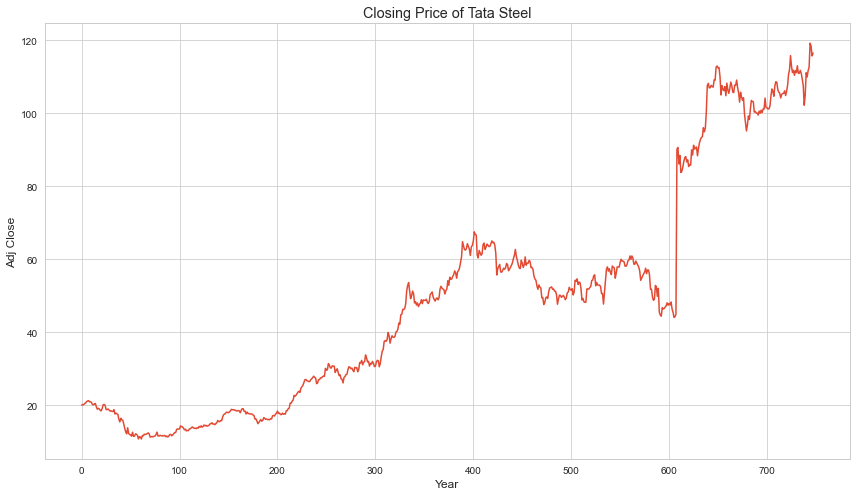

In [8]:
# Let's see a historical view of the closing price
plt.figure(figsize=(12, 7))

df['Adj Close'].plot()
plt.ylabel('Adj Close')
plt.xlabel('Year')
plt.title("Closing Price of Tata Steel")
    
plt.tight_layout()

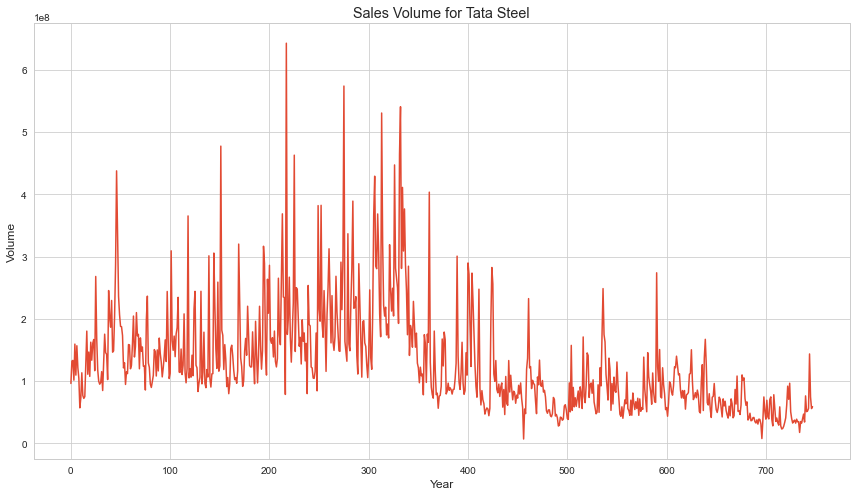

In [9]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(12, 7))


df['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel('Year')
plt.title("Sales Volume for Tata Steel")
    
plt.tight_layout()

<Figure size 864x504 with 0 Axes>

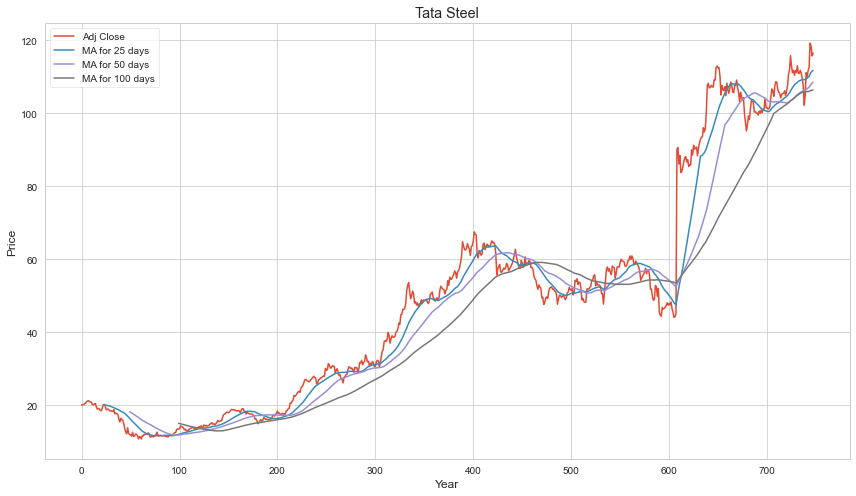

In [10]:
plt.figure(figsize=(12, 7))
ma_day = [25, 50, 100]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df[column_name] = df['Adj Close'].rolling(ma).mean()

df[['Adj Close', 'MA for 25 days', 'MA for 50 days', 'MA for 100 days']].plot()
plt.ylabel('Price')
plt.xlabel('Year')
plt.title("Tata Steel")

plt.gcf().set_size_inches(12, 7)

plt.tight_layout()

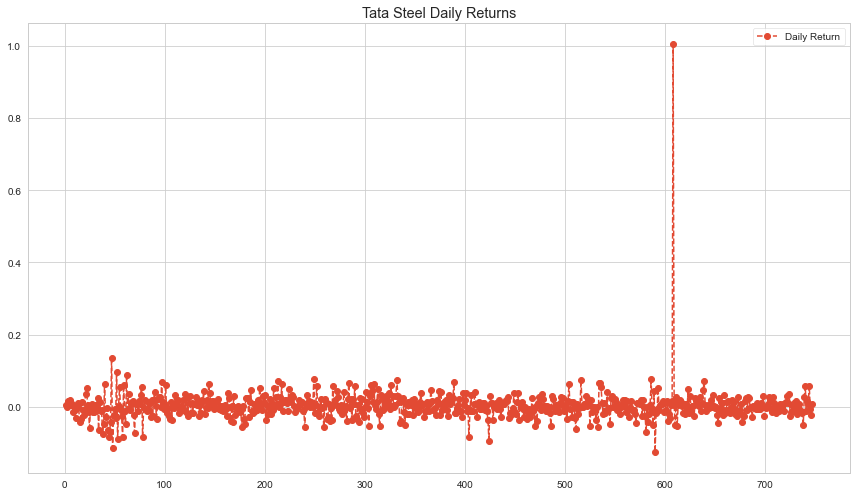

In [11]:
df['Daily Return'] = df['Adj Close'].pct_change()

plt.figure(figsize=(12, 7))
df['Daily Return'].plot(legend=True, linestyle='--', marker='o').set_title('Tata Steel Daily Returns')

plt.tight_layout()

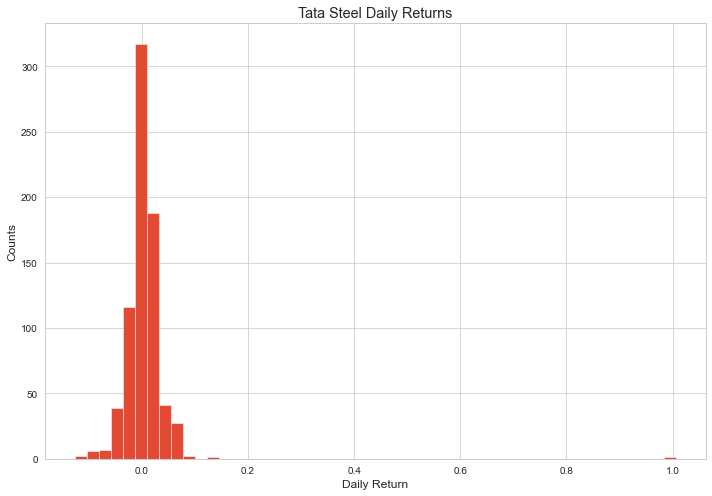

In [12]:
plt.figure(figsize=(10, 7))

df['Daily Return'].hist(bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.title('Tata Steel Daily Returns')
    
plt.tight_layout()

Text(50, 50, 'Tata Steel')

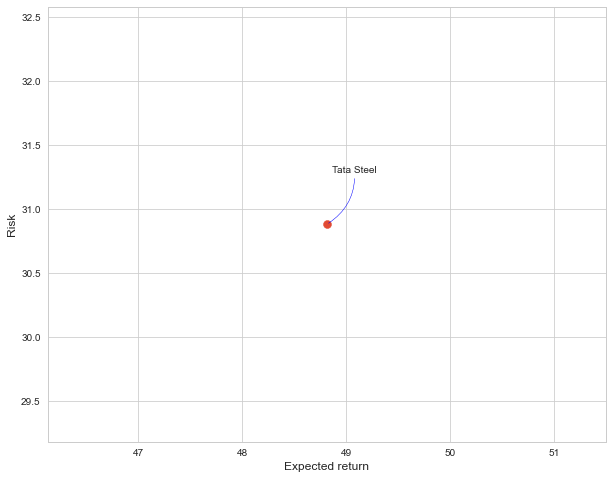

In [13]:
# Value at Risk

area = np.pi * 20
rets = df["Adj Close"]

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')


plt.annotate('Tata Steel', xy=(rets.mean(), rets.std()), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
             arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

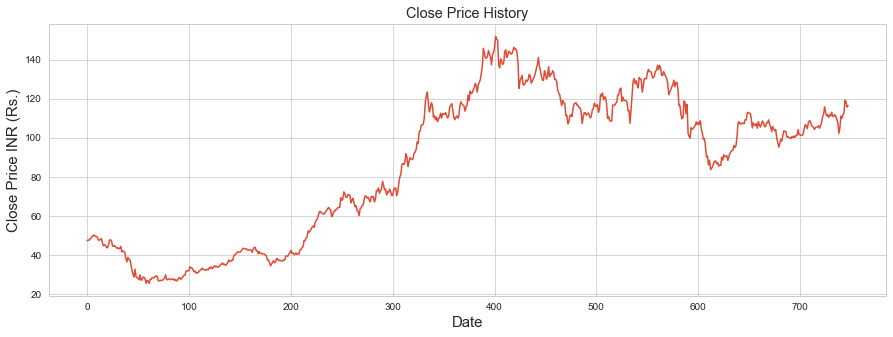

In [14]:
plt.figure(figsize=(15,5))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price INR (Rs.)', fontsize=15)
plt.show()

# Preprocessing Data for the Model

In [15]:
df.drop(['MA for 25 days', 'MA for 50 days', 'MA for 100 days', 'Daily Return'], axis=1)

,Code,Date,Open,High,Low,Close,Adj Close,Volume
0,TATASTEEL.NS,2020-01-06,48.000000,48.000000,47.055000,47.325001,20.056345,96016080
1,TATASTEEL.NS,2020-01-07,47.549999,48.459999,47.355000,47.610001,20.177128,131957880
2,TATASTEEL.NS,2020-01-08,47.165001,47.814999,46.700001,47.525002,20.141106,133048410
3,TATASTEEL.NS,2020-01-09,48.500000,48.599998,47.910000,48.314999,20.475906,101311520
4,TATASTEEL.NS,2020-01-10,48.549999,49.384998,48.000000,48.619999,20.605165,159276340
...,...,...,...,...,...,...,...,...
743,TATASTEEL.NS,2022-12-30,112.900002,114.750000,112.099998,112.650002,112.650002,56048485
744,TATASTEEL.NS,2023-01-02,114.400002,119.699997,113.750000,119.250000,119.250000,143444095
745,TATASTEEL.NS,2023-01-03,119.800003,120.500000,117.750000,118.449997,118.449997,74419090
746,TATASTEEL.NS,2023-01-04,118.750000,119.050003,115.349998,115.750000,115.750000,55634568


In [28]:
#Split data into training set and test set
dataset_train=df.iloc[0:int(0.8*len(df)),:]
dataset_test=df.iloc[int(0.8*len(df)):,:]
############# NOTE #################
#TO PREDICT STOCK PRICES OF NEXT N DAYS, STORE PREVIOUS N DAYS IN MEMORY WHILE TRAINING
# HERE N=7
###dataset_train=pd.read_csv('Google_Stock_Price_Train.csv')
training_set=df.iloc[:,4:5].values# 1:2, to store as numpy array else Series obj will be stored
#select cols using above manner to select as float64 type, view in var explorer

#Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler(feature_range=(0,1))#Scaled values btween 0,1
training_set_scaled=sc.fit_transform(training_set)
#In scaling, fit_transform for training, transform for test
        
#Creating data stucture with 7 timesteps and 1 output. 
#7 timesteps meaning storing trends from 7 days before current day to predict 1 next output
X_train=[]#memory with 7 days from day i
y_train=[]#day i
for i in range(14,len(training_set_scaled)):
    X_train.append(training_set_scaled[i-14:i,0])
    y_train.append(training_set_scaled[i,0])
#Convert list to numpy arrays
X_train=np.array(X_train)
y_train=np.array(y_train)
X_forecast=np.array(X_train[-1,1:])
X_forecast=np.append(X_forecast,y_train[-1])
#Reshaping: Adding 3rd dimension
X_train=np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))#.shape 0=row,1=col
X_forecast=np.reshape(X_forecast, (1,X_forecast.shape[0],1))
#For X_train=np.reshape(no. of rows/samples, timesteps, no. of cols/features)

X_train

array([[[0.17704892],
        [0.17946651],
        [0.1741881 ],
        ...,
        [0.17942621],
        [0.17918446],
        [0.17914416]],

       [[0.17946651],
        [0.1741881 ],
        [0.18393908],
        ...,
        [0.17918446],
        [0.17914416],
        [0.18180353]],

       [[0.1741881 ],
        [0.18393908],
        [0.18466436],
        ...,
        [0.17914416],
        [0.18180353],
        [0.1686276 ]],

       ...,

       [[0.69316622],
        [0.68994274],
        [0.67986941],
        ...,
        [0.67503422],
        [0.70122489],
        [0.7145217 ]],

       [[0.68994274],
        [0.67986941],
        [0.69074866],
        ...,
        [0.70122489],
        [0.7145217 ],
        [0.74675637]],

       [[0.67986941],
        [0.69074866],
        [0.67624304],
        ...,
        [0.7145217 ],
        [0.74675637],
        [0.72741556]]])

In [29]:
print('X_train Shape',X_train.shape)
print('X_forecast Shape',X_forecast.shape)

X_train Shape (734, 14, 1)
X_forecast Shape (1, 14, 1)


# Building the Neural Network

In [18]:
# For creating model and training
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

In [78]:
#Initialise RNN
regressor = tf.keras.Sequential()

#Add first LSTM layer
regressor.add(LSTM(units=70,return_sequences=True,input_shape=(X_train.shape[1],1)))
#units=no. of neurons in layer
#input_shape=(timesteps,no. of cols/features)
#return_seq=True for sending recc memory. For last layer, retrun_seq=False since end of the line
regressor.add(Dropout(0.1))
        
#Add 2nd LSTM layer
regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.1))
        
#Add 3rd LSTM layer
regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.1))
        
#Add 4th LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.1))
        
#Add o/p layer
regressor.add(Dense(units=1))
        
#Compile
regressor.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
        
#Training
history = regressor.fit(X_train,y_train,epochs=60,batch_size=16 )
#For lstm, batch_size=power of 2

Epoch 1/60
46/46 [==============================] - 14s 63ms/step - loss: 0.1194 - mse: 0.1194 - mae: 0.2595
Epoch 2/60
46/46 [==============================] - 3s 62ms/step - loss: 0.0060 - mse: 0.0060 - mae: 0.0582: 0s - loss: 0.0062 - mse: 0.0062 - 
Epoch 3/60
46/46 [==============================] - 3s 61ms/step - loss: 0.0052 - mse: 0.0052 - mae: 0.0530
Epoch 4/60
46/46 [==============================] - 3s 61ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0516
Epoch 5/60
46/46 [==============================] - 3s 57ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0451
Epoch 6/60
46/46 [==============================] - 3s 60ms/step - loss: 0.0046 - mse: 0.0046 - mae: 0.0513
Epoch 7/60
46/46 [==============================] - 3s 56ms/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0491
Epoch 8/60
46/46 [==============================] - 3s 59ms/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0476
Epoch 9/60
46/46 [==============================] - 3s 60ms/step - loss: 0.0046 - mse: 0.0046 - mae

# Testing the Neural Network

In [79]:
#Testing
###dataset_test=pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price=dataset_test.iloc[:,4:5].values
        
#To predict, we need stock prices of 7 days before the test set
#So combine train and test set to get the entire data set
dataset_total=pd.concat((dataset_train['Close'],dataset_test['Close']),axis=0) 
testing_set=dataset_total[ len(dataset_total) -len(dataset_test) -14: ].values
testing_set=testing_set.reshape(-1,1)
#-1=till last row, (-1,1)=>(80,1). otherwise only (80,0)
        
#Feature scaling
testing_set=sc.transform(testing_set)
        
#Create data structure
X_test=[]
Y_test=[]
for i in range(14,len(testing_set)):
    X_test.append(testing_set[i-14:i,0])
    Y_test.append(testing_set[i,0])
    #Convert list to numpy arrays
X_test=np.array(X_test)
Y_test=np.array(Y_test)
#Reshaping: Adding 3rd dimension
X_test=np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

X_test

array([[[0.68188408],
        [0.68712222],
        [0.7557821 ],
        ...,
        [0.64195343],
        [0.64856153],
        [0.65492789]],

       [[0.68712222],
        [0.7557821 ],
        [0.74897252],
        ...,
        [0.64856153],
        [0.65492789],
        [0.66943345]],

       [[0.7557821 ],
        [0.74897252],
        [0.70215162],
        ...,
        [0.65492789],
        [0.66943345],
        [0.65794989]],

       ...,

       [[0.70888066],
        [0.69195741],
        [0.69276333],
        ...,
        [0.69840437],
        [0.70565718],
        [0.75884437]],

       [[0.69195741],
        [0.69276333],
        [0.69880733],
        ...,
        [0.70565718],
        [0.75884437],
        [0.75239741]],

       [[0.69276333],
        [0.69880733],
        [0.69195741],
        ...,
        [0.75884437],
        [0.75239741],
        [0.73063904]]])

In [73]:
print('X_test Shape',X_test.shape)

X_test Shape (150, 14, 1)


MAE: 2.340290527343751
Max Error: 10.596290588378906
RMSE: 3.198807650118611
MAPE: 2.35 %


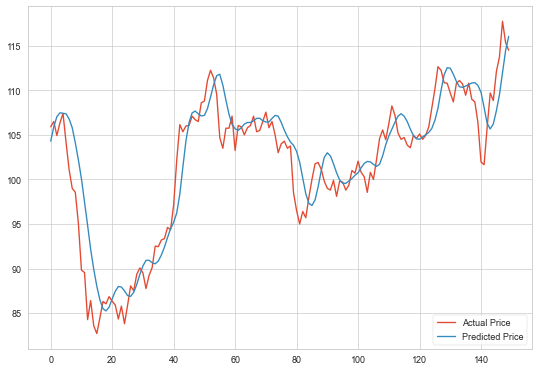

In [90]:
from sklearn.metrics import r2_score, mean_absolute_error, max_error


#Testing Prediction
predicted_stock_price=regressor.predict(X_test)
        
#Getting original prices back from scaled values
predicted_stock_price=sc.inverse_transform(predicted_stock_price)
fig = plt.figure(figsize=(10,7),dpi=65)
plt.plot(real_stock_price,label='Actual Price')  
plt.plot(predicted_stock_price,label='Predicted Price')
          
plt.legend(loc=4)

#Metrics

mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print("MAE:", mae)

var2 = max_error(real_stock_price, predicted_stock_price)
print('Max Error:',var2)

rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))        
print("RMSE:",rmse)

mape = np.mean(np.abs(predicted_stock_price - real_stock_price)/np.abs(real_stock_price))
print("MAPE:",np.round(mape*100,2),'%')

In [81]:
print('Real Stock Price\tPredicted Stock Price')
for i in range(80,90):
    print(np.round(real_stock_price[i,0], 3),'\t\t\t', np.round(predicted_stock_price[i,0], 3))

Real Stock Price	Predicted Stock Price
96.5 			 103.147
95.0 			 101.926
96.4 			 100.143
95.7 			 98.374
98.0 			 97.318
100.0 			 97.073
101.75 			 97.691
101.9 			 99.169
101.15 			 100.947
99.8 			 102.469


In [82]:
#Forecasting Prediction
forecasted_stock_price=regressor.predict(X_forecast)
        
#Getting original prices back from scaled values
forecasted_stock_price=sc.inverse_transform(forecasted_stock_price)
        
lstm_pred=forecasted_stock_price[0,0]
print()
print("##############################################################################")
print("Tomorrow's Closing Price Prediction by LSTM: ",lstm_pred)

print("##############################################################################")


##############################################################################
Tomorrow's Closing Price Prediction by LSTM:  115.0066
##############################################################################


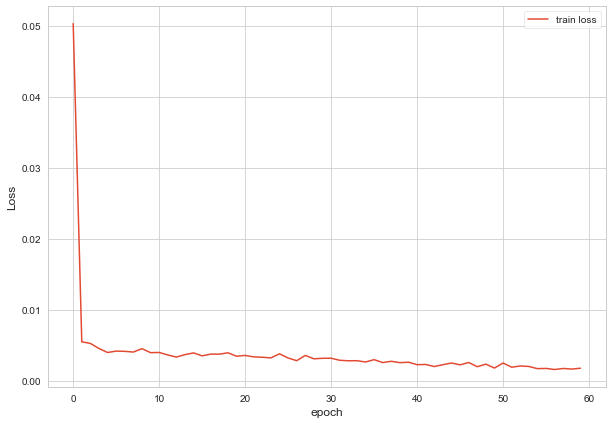

In [84]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='train loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

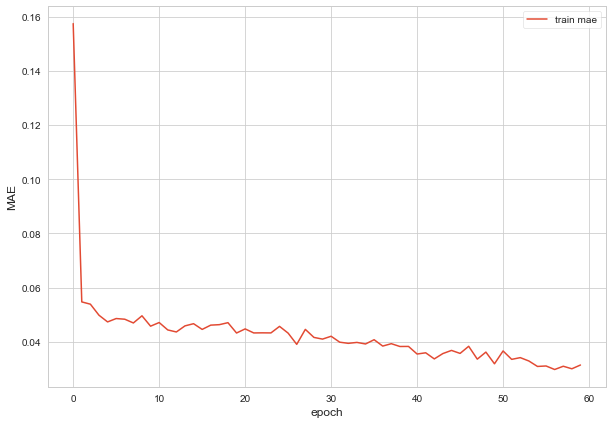

In [83]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['mae'], label='train mae')
plt.xlabel("epoch")
plt.ylabel("MAE")
plt.legend()

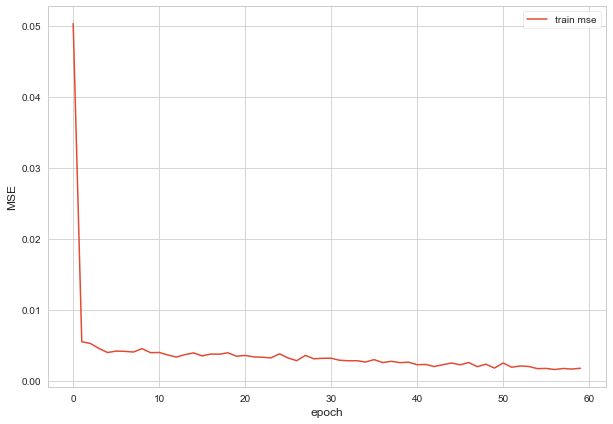

In [85]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['mse'], label='train mse')
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.legend()